# Figure 1

DATASETS

for our methods overcluster with 15 clusters:

- Noisy circles
- Noisy moons
- 3 Gaussians
- Aniso
- blobs
- no structure

after decide on ~4-5 datasets for main figure, rest in Appendix

METHODS

- K-Means
- GMM
- TMM
- Leiden
- Agglomerative + dendrogram
- HDBSCAN
- Leiden + PAGA
- GMM + NEB
- GMM + dip-statistic
- TMM + NEB
- TMM + dip-statistic

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
from corc.graph_metrics import paga, gwg, gwgmara, neb
from corc.graph_metrics import tmm_gmm_neb
# from corc import complex_datasets, datasets2d
import corc.utils



In [5]:
import numpy as np
from scipy.sparse import csr_matrix
import scanpy as sc
import anndata as ad

class Leiden():
    def __init__(self, resolution=1.0, seed=42):
        self.resolution = resolution
        self.seed = seed

    def fit(self, data):
        self.data = data

        counts = csr_matrix(self.data, dtype=np.float32)
        adata = ad.AnnData(counts)

        self.adata = adata

        sc.pp.neighbors(self.adata)
        sc.tl.leiden(self.adata, flavor="igraph", n_iterations=2, resolution=self.resolution, random_state=self.seed)

        self.labels_ = self.adata.obs['leiden']

In [39]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np
import studenttmixture

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1000
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# bowtie = datasets2d.bowtie_dataset(n=n_samples)
# zigzag = datasets2d.zigzag_dataset(n=n_samples)
# zigzig = datasets2d.zigzig_dataset(n=n_samples)
# uniform_circle = datasets2d.uniform_circle(n=n_samples)

# clusterlab10 = datasets2d.clusterlab_dataset10()

# ============
# Set up cluster parameters
# ============


default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
    "dim":2,
    "n_components":15,
    "resolution":1.0,
    "resolution_leiden":1.0,
}

datasets = [
    # (
    #     noisy_circles,
    #     {
    #         "damping": 0.77,
    #         "preference": -240,
    #         "quantile": 0.2,
    #         "n_clusters": 2,
    #         "min_samples": 7,
    #         "xi": 0.08,
    #         "resolution":1.0,
    #         "resolution_leiden":0.01,
    #     },
    # ),
    # (
    #     noisy_moons,
    #     {
    #         "damping": 0.75,
    #         "preference": -220,
    #         "n_clusters": 2,
    #         "min_samples": 7,
    #         "xi": 0.1,
    #         "resolution":0.5,
    #         "resolution_leiden":0.01,
    #     },
    # ),
    # (
    #     varied,
    #     {
    #         "eps": 0.18,
    #         "n_neighbors": 2,
    #         "min_samples": 7,
    #         "xi": 0.01,
    #         "min_cluster_size": 0.2,
    #         "resolution":0.5,
    #         "resolution_leiden":0.1,
    #     },
    # ),
    # (
    #     aniso,
    #     {
    #         "eps": 0.15,
    #         "n_neighbors": 2,
    #         "min_samples": 7,
    #         "xi": 0.1,
    #         "min_cluster_size": 0.2,
    #         "resolution":0.1,
    #         "resolution_leiden":0.1,
    #     },
    # ),
    (
        blobs, 
        {
            "min_samples": 7, 
            "xi": 0.1, 
            "min_cluster_size": 0.2,
            "resolution":0.1,
            "resolution_leiden":0.1,
            }
    ),
    # (
    #     no_structure, 
    #     {
    #         "resolution":0.1,
    #         "resolution_leiden":0.01,
    #     }
    # ),
    # (
    #     worms, 
    #     {
    #         "resolution":0.01,
    #         "resolution_leiden":0.01,
    #     }
    # ),
    # (
    #     bowtie, 
    #     {
    #         "resolution":0.1,
    #         "resolution_leiden":0.1,
    #     }
    # ),
    # (
    #     zigzag, 
    #     {
    #         "resolution":0.01,
    #         "resolution_leiden":0.01,
    #     }
    # ),
    # (
    #     zigzig, 
    #     {
    #         "resolution":0.01,
    #         "resolution_leiden":0.01,
    #     }
    # ),
    # (
    #     uniform_circle, 
    #     {
    #         "resolution":0.1,
    #         "resolution_leiden":0.1,
    #     }
    # ),
    # (
    #     clusterlab10, 
    #     {
    #         "resolution":1.0,
    #         "resolution_leiden":0.01,
    #     }
    # ),
]

tmm: 100%|██████████| 105/105 [00:24<00:00,  4.22it/s]


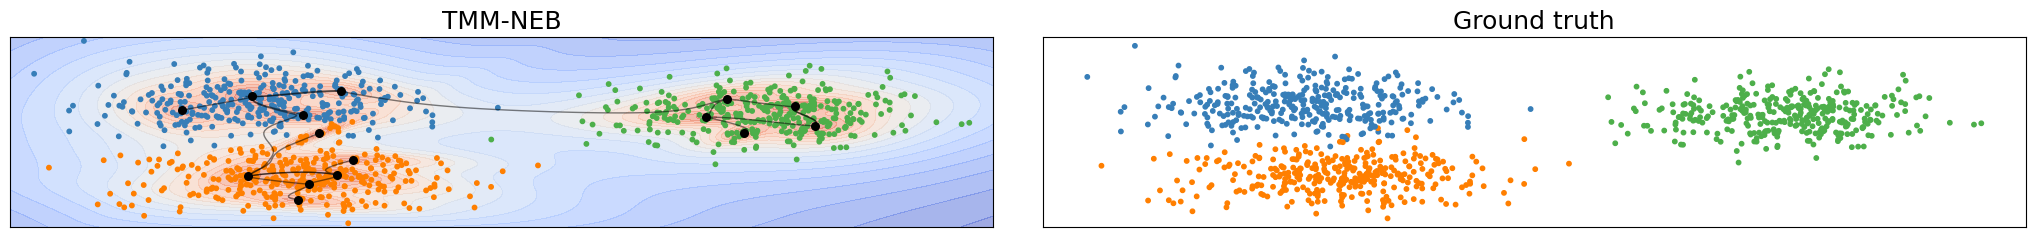

In [40]:
plt.figure(figsize=(9 * 2 + 3, len(datasets) * 2))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset
    y = [0]*len(X) if y is None else np.array(y, dtype='int')

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )
    tmm = studenttmixture.EMStudentMixture(
        n_components=params["n_clusters"],
        n_init=5,
        fixed_df=False,#True,
        # df=1.0,
        init_type="k++",
        random_state=params["random_state"]
        )
    leiden = Leiden(
        resolution=params["resolution_leiden"], 
        seed=params["random_state"]
        )
    mgwg = gwg.GWG(
        latent_dim=params["dim"], 
        n_components=params["n_components"],
        n_neighbors=params["n_neighbors"],
        seed=params["random_state"]
        )
    mgwgmara = gwgmara.GWGMara(
        latent_dim=params["dim"], 
        n_components=params["n_components"],
        n_neighbors=params["n_neighbors"],
        seed=params["random_state"]
        )
    mpaga = paga.PAGA(
        latent_dim=params["dim"], 
        resolution=params["resolution"], 
        seed=params["random_state"]
        )
    tmm_neb = neb.NEB(
        latent_dim=params["dim"],
        n_components=params["n_components"],
        seed=params["random_state"],
        mixture_model_type="tmm",
        n_init=1,
        optimization_iterations=50,
    )
    gmm_neb = neb.NEB(
        latent_dim=params["dim"],
        n_components=params["n_components"],
        seed=params["random_state"],
        mixture_model_type="gmm",
        n_init=5,
        optimization_iterations=50,
    )
    clustering_algorithms = (
        # ("MiniBatch\nKMeans", two_means),
        # ("Agglomerative\nClustering", average_linkage),
        # ("HDBSCAN", hdbscan),
        # ("Gaussian\nMixture", gmm),
        # ("t-Student\nMixture", tmm),
        # ("Leiden", leiden),
        # ("PAGA", mpaga),
        # ("GWG-dip", mgwgmara),
        # ("GWG-pvalue", mgwg),
        # ("Affinity\nPropagation", affinity_propagation),
        # ("MeanShift", ms),
        # ("Spectral\nClustering", spectral),
        # ("Ward", ward),
        # ("DBSCAN", dbscan),
        # ("OPTICS", optics),
        # ("BIRCH", birch),
        ("TMM-NEB", tmm_neb),
        # ("GMM-NEB", gmm_neb),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            if hasattr(algorithm, "predict_with_target"):
                y_pred = algorithm.predict_with_target(X,len(np.unique(y))).astype(int)
            else:
                y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms)+1, plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(max(y_pred), max(y)) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        
        if name in ["TMM-NEB", "GMM-NEB"]:
            linspace_x = np.linspace(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1, 128)
            linspace_y = np.linspace(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1, 128)
            XY = np.stack(np.meshgrid(linspace_x, linspace_y), -1)
            tmm_probs = algorithm.mixture_model.score_samples(XY.reshape(-1, 2)).reshape(128, 128)
            plt.contourf(linspace_x, linspace_y, tmm_probs, levels=20, cmap="coolwarm", alpha=0.5)
            
            
            # algorithm.pairs_ = [(10,i) for i in range(15)]
            

        # reorder colors for better plots
        y_pred_permuted = corc.utils.reorder_colors(y_pred,y)
        
        # plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred_permuted])

        if name in ["GWG-dip", "GWG-pvalue", "PAGA", "TMM-NEB", "GMM-NEB"]:
            algorithm.plot_graph()

        # plt.xlim(-2.5, 2.5)
        # plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1
    
    # plot ground truth
    plt.subplot(len(datasets), len(clustering_algorithms)+1, plot_num)
    if i_dataset == 0:
        plt.title('Ground truth', size=18)
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y])
    # plt.xlim(-2.5, 2.5)
    # plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plot_num += 1

plt.show()

In [44]:
algo = clustering_algorithms[0][1]

In [49]:
algo.paths_[(0,1)].shape

(1024, 2)